# Homework 8

## FINM 35700 - Spring 2025

### UChicago Financial Mathematics

### Due Date: 2025-05-20

* Matheus Raka Pradnyatama
* matheusraka@uchicago.edu

In [131]:
import pandas as pd
import numpy as np
import datetime
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import QuantLib as ql
import datetime as dt
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.integrate import quad
from scipy.optimize import fsolve
from scipy.optimize import root_scalar
from scipy.optimize import minimize
from scipy.special import comb
from sklearn.decomposition import PCA

# The code is made with the help of OpenAI's ChatGPT.

In [132]:
# import tools from previous homeworks
from credit_market_tools import *

# Use static calculation/valuation date of 2024-12-13, matching data available in the market prices EOD file
calc_date = ql.Date(13, 12, 2024)
ql.Settings.instance().evaluationDate = calc_date

# Calculation/valuation date as pd datetime
as_of_date = pd.to_datetime('2024-12-13')

In [133]:
def calc_d1_d2_tilde(A,r,sigma_A,T,K, C):
    d1_tilde = (np.log(C * A/K) + (r + 0.5 * sigma_A**2)* T ) / (sigma_A * np.sqrt(T))
    d2_tilde = (np.log(C * A/K) + (r - 0.5 * sigma_A**2)* T ) / (sigma_A * np.sqrt(T))
    return (d1_tilde, d2_tilde)

def conversion_option_value(A,r,sigma_A,T,K, C):
    d1_tilde, d2_tilde = calc_d1_d2_tilde(A,r,sigma_A,T,K, C)
    conv_opt = C * A * norm.cdf(d1_tilde) - K * np.exp(-r * T) * norm.cdf(d2_tilde)
    return conv_opt

def fairValueRiskyBond_conv(A,r,sigma_A,T,K, C):
    d1, d2 = calc_d1_d2(A,r,sigma_A,T,K)
    B0 = A * norm.cdf(-d1) + K * np.exp(-r * T) * norm.cdf(d2)
    conv_opt = conversion_option_value(A,r,sigma_A,T,K, C)
    CB0 = B0 + conv_opt
    return CB0

def fairValueEquity_conv(A,r,sigma_A,T,K, C):
    d1, d2 = calc_d1_d2(A,r,sigma_A,T,K)
    E0  = A * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)
    conv_opt = conversion_option_value(A,r,sigma_A,T,K, C) 
    EB0 = E0 - conv_opt
    return EB0

def riskyBondYield_conv(A,r,sigma_A,T,K, C):
    CB0 = fairValueRiskyBond_conv(A, r, sigma_A, T, K, C)
    bond_yield = - np.log(CB0/K) / T       
    return bond_yield

def riskyBondCreditSpread_conv(A,r,sigma_A,T,K, C):
    bond_yield = riskyBondYield_conv(A,r,sigma_A,T,K, C)
    bond_credit_spread = bond_yield - r
    return bond_credit_spread

-----------------------------------------------------------
# Problem 1: Options Pricing and Volatility Smiles in the Merton Structural Credit Model
## Follow Lecture 7, "Structural Credit Default Models"

We assume the following input values in the Merton Structural Credit Model
- Initial Assets of 1 (e.g. think about 1 $BN in assets at time 0)
- Face value of Liabilities K: 0.9 (e.g. initial leverage of 90%)
- Bond maturity T = 5 years
- Asset volatility at 20% (log-normal annualized vol)
- Flat risk-free interest rates of 4%
- Log-normal distribution of assets at time T, using Lecture 7 Formula (27):

$A_{T}=A_{0}\cdot\exp\left[\left(r-\frac{1}{2}\sigma_{A}^{2}\right)\cdot T+\sigma_{A}\cdot W_{T}\right]$


## a. Distributions of Assets and Equity fair values at time t = 1 year


Use the following discretization grid for Asset at time t: [a from 0.02 to 2 in steps of 0.02].

Compute the density (PDF) and cumulative density (CDF) of Assets at time t.

For each value of the assets, compute the fair value of Equity at time t.

Plot the results: Assets PDF, Assest CDF and Equity fair value at time t.

You can use lognorm from scipy.stats for the log-normal distribution PDF/CFD.

Mean for Normal Distribution: 0.019999999999999997
Standard Deviation for Normal Distribution: 0.2


,Asset_at_time_t,PDF,CDF,Equity_Fair_Value
0,0.02,1.167003e-82,2.368260e-86,2.017372e-22
1,0.04,5.613547e-56,2.762629e-59,6.917609e-16
2,0.06,8.691673e-43,7.326011e-46,1.192871e-12
3,0.08,1.640403e-34,2.049501e-37,1.297857e-10
4,0.10,1.036084e-28,1.771416e-31,3.514460e-09


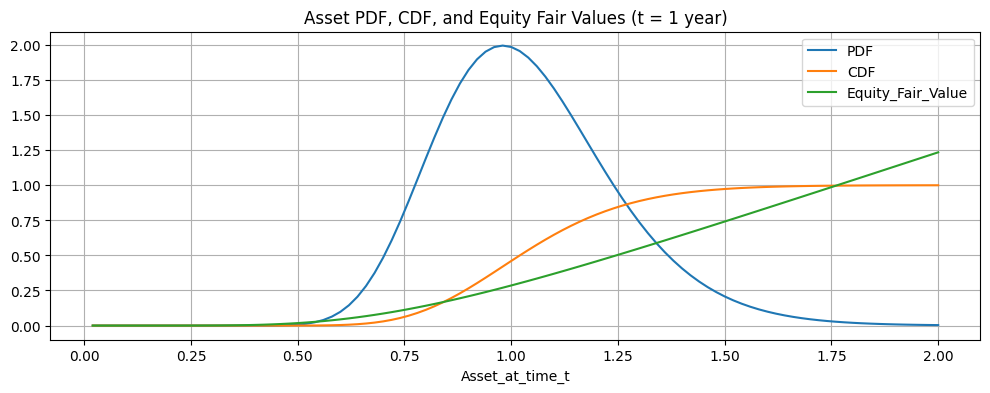

In [134]:
# Parameters
A_0 = 1         # Initial Assets
K = 0.9         # Face Value of Liabilities
T = 5           # Bond maturity T / Merton Model time horizon T
t = 1           # Analysis time horizon t
sigma_A = 0.2   # Assets volatility
r = 0.04        # Risk-free interest rate

# Generate asset grid
step = 0.02
assets_grid = np.arange(0.02, 2+step, step)
# print(assets_grid)

# Mean and Standard Deviation for Normal Distribution
mu = np.log(A_0) + (r - 0.5 * sigma_A**2) * t 
sigma_A = sigma_A * np.sqrt(t)
print(f'Mean for Normal Distribution: {mu}')
print(f'Standard Deviation for Normal Distribution: {sigma_A}')

# Create a log-normal distribution instance
assets_dist = lognorm(s = sigma_A, scale = np.exp(mu))

# Calculate the distribution functions
assets_pdf = assets_dist.pdf(assets_grid)
assets_cdf = assets_dist.cdf(assets_grid)

df_assets  = pd.DataFrame({
    'Asset_at_time_t': assets_grid,
    'PDF': assets_pdf,
    'CDF': assets_cdf,
})

# Compute Fair Value of Equity at time-t (use T-t) and put on df
E_t = [fairValueEquity(asset,r,sigma_A,T-t,K) for asset in assets_grid]
df_assets['Equity_Fair_Value'] = E_t

display(df_assets.head())

# Plot the Asset PDFs, CFDs and Equity fair values at t = 1 year
df_assets.plot(x="Asset_at_time_t", title='Asset PDF, CDF, and Equity Fair Values (t = 1 year)', grid=True, figsize=(12,4)); # , style='-*'

## b. Compute the value of an Europen ATM (At-The-Money) Call option with maturity t = 1 year.

For ATM options, the strike k equals the equity value at time 0, i.e. $k = E_0$.

The Call Option value can be obtained by numerical integration of the call payoff function against the log-normal density of A_t, as derived in Lecture 7 formula (47).

You can use quad from scipy.integrate for numerical integration.

$EquityCall\left(E_{0},k,t\right)=e^{-r\cdot t}\cdot\mathbb{E}\left[\left(E_{t}-k\right)^{+}|\mathcal{F}_{0}\right]$

$=e^{-r\cdot t}\cdot\mathbb{E}\left[\left(Call\left(A_{t},K,T-t,\sigma_{A},r,\right)-k\right)^{+}|\mathcal{F}_{0}\right]$

$=\int_{-\infty}^{\infty}e^{-r\cdot t}\cdot\left(Call\left(x,K,T-t,\sigma_{A},r,\right)-k\right)^{+} \cdot \phi_{A_{t}} \, dx$

In [135]:
# Fair Value of Equity at time-0
E0 = fairValueEquity(A_0,r,sigma_A,T,K)

# Strike k for ATM option is equal to the Fair Value of Equity at time-0
k_atm = E0

print(f"Fair Value of Equity at time-0 (ATM strike k) = {k_atm:.4f}")

Fair Value of Equity at time-0 (ATM strike k) = 0.3188


In [136]:
# merton_structural_credit_model_call
def merton_structural_credit_model_equity_call(k):

    # Numerical integration
    def integrand(A_t):
        E_t = fairValueEquity(A_t, r, sigma_A, T-t, K)
        call_option_payout = np.maximum(E_t - k, 0)
        return np.exp(-r * t) * call_option_payout * assets_dist.pdf(A_t)

    # Integrate over A_t from from 0 to infinity
    europen_call_price, _ = quad(integrand, 0, np.inf)    
    return(europen_call_price)

# European Call Price ATM 
european_call_price_atm = merton_structural_credit_model_equity_call(k_atm)

print(f"Numerically Integrated Europen Call Price in Merton model: {european_call_price_atm:.4f}")

Numerically Integrated Europen Call Price in Merton model: 0.0714


## c. Compute the Implied Volatility of the ATM European Call Option

Implement a function to compute the Implied Volatility in the Black-Scholes model (using European Call option price as input)

Compute the Implied Volatility of the ATM European Call Option.

Use a numerical root finder, e.g. root_scalar from scipy.optimize.

In [137]:
# Analytical Black-Scholes price
def black_scholes_call(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# black_scholes_implied_vol
def black_scholes_implied_vol(S_0, K, T, r, call_price):

    # call_price_from_implied_vol
    call_price_from_implied_vol = lambda sigma: black_scholes_call(S_0, K, T, r, sigma) - call_price

    # use 1-dimensional root finder
    root_finder_implied_vol_sol = root_scalar(call_price_from_implied_vol, bracket=[0.001, 2], method='brentq', xtol=1e-6)    

    # root_scalar() convergence details
    # print(root_finder_implied_vol_sol)

    return root_finder_implied_vol_sol.root

In [138]:
S_0 = E0 # Equity Value at time-0
call_price = european_call_price_atm # Call price computed earlier

option_implied_vol_at_t =  black_scholes_implied_vol(S_0, k_atm, t, r, call_price)
print(f"Implied Vol of the ATM European Call Option: {option_implied_vol_at_t:.4f}")

Implied Vol of the ATM European Call Option: 0.5271


## d. Plot the option Implied Volatility Smile in the Merton model

Use a grid of strikes [k from 80% to 120% in steps of 5%], relative to the spot equity price E_0.

Compute the European Call options prices and the corresponding option Implied Volatilities on the above grid.
Plot the Implied Volatility smile (Implied Volatities by strikes).

,Percent_of_E0,Strike,call_option_price,sigma_E
0,0.80,0.255058,0.104333,0.547030
1,0.85,0.270999,0.095195,0.541633
2,0.90,0.286940,0.086669,0.536506
3,0.95,0.302881,0.078746,0.531671
4,1.00,0.318822,0.071403,0.527052
5,1.05,0.334763,0.064619,0.522647
6,1.10,0.350704,0.058371,0.518435
7,1.15,0.366646,0.052632,0.514401
8,1.20,0.382587,0.047375,0.510532


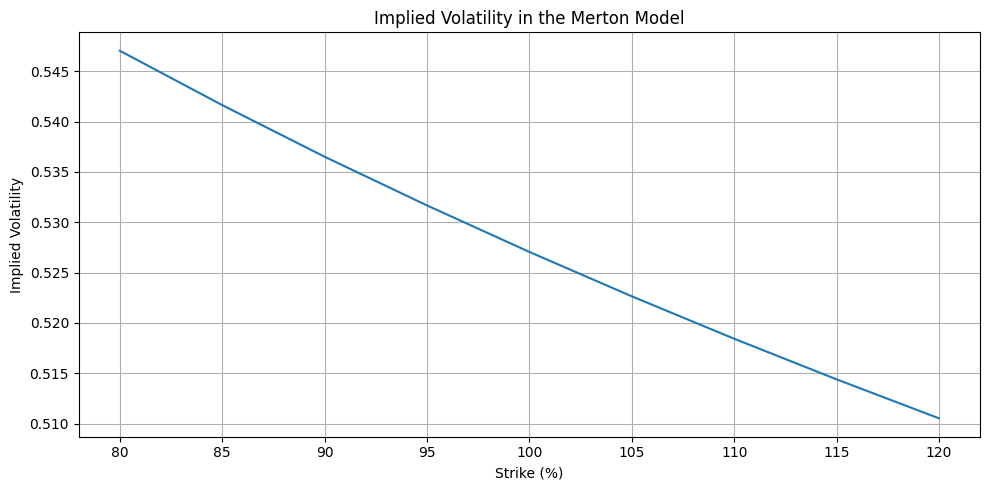

In [139]:
# ----- Initial Parameters -----
A_0 = 1         # Initial Assets
K = 0.9         # Face Value of Liabilities
T = 5           # Bond maturity T / Merton Model time horizon T
t = 1           # Analysis time horizon t
sigma_A = 0.2   # Assets volatility
r = 0.04        # Risk-free interest rate

# ----- Additional Parameters -----
S_0 = E0 # Equity Value at time-0
call_price = european_call_price_atm # Call price computed earlier

# ----- Grid -----
step = 5 / 100
# Should be:
arrange_values = np.arange(0.8, 1.20 + step, step)
# arrange_values = np.arange(0.50, 1.50, step)

# ----- Store Results -----
metrics = []

for percent_of_E0 in arrange_values:
    
    k = percent_of_E0 * E0
    call_option_price = merton_structural_credit_model_equity_call(k)
    sigma_E = black_scholes_implied_vol(S_0, k, t, r, call_option_price)

    metrics.append({
        'Percent_of_E0': percent_of_E0,
        'Strike': k,
        'call_option_price': call_option_price,
        'sigma_E': sigma_E,
    })

df_metrics = pd.DataFrame(metrics)
display(df_metrics)

plt.figure(figsize=(10, 5))
x_values = df_metrics['Percent_of_E0'] * 100
y_values = df_metrics['sigma_E']
plt.plot(x_values, y_values)
plt.title('Implied Volatility in the Merton Model')
plt.xlabel('Strike (%)')
plt.ylabel('Implied Volatility')
plt.grid(True)
plt.tight_layout()
plt.show()

-----------------------------------------------------------
# Problem 2: Pricing Convertible Bonds in the Merton Structural Credit Model
## Follow Lecture 7, "Structural Credit Default Models"

A convertible bond is a type of corporate bond that can be converted into a predetermined number of the issuing company’s common stock ("conversion ratio") at the bondholder’s discretion, typically at specific dates. The conversion to equity is optional, so bondholders can choose to hold the bond to maturity for interest and principal repayment instead.

Benefits for convertible bond investors:
- Income from interest payments.
- Potential capital gains if the stock price increases and conversion is profitable.
- Lower risk than owning stock directly, as bondholders are prioritized over shareholders in case of bankruptcy.

Benefits for convertible bond issuers:
- Lower interest rates than regular bonds due to the conversion feature’s appeal.
- Potential to reduce debt if bonds are converted to equity.


The Merton structural credit model (1974) provides a framework for pricing convertible bonds by treating them as hybrid instruments with both debt and equity characteristics.

### Recap of model assumptions

- Constant interest rates r

- Constant asset volatility $\sigma_{A}$

- Asset value process $A_{t}$ follows a geometric Brownian motion with drift r under risk neutral measure $\mathbb{P}$

- Liabilities consist of one zero-coupon convertible bond with face value K and maturity T

- Conversion details: at time T, the convertible bond can be converted to equity at a conversion ratio of $C \in (0,1)$ relative to the assets $A_{T}$ (i.e. for a convertible bond payout of $C \cdot A_{T}$ at time T, in case of conversion)

- Credit default triggered if value of assets $A_{T}$ is below liabilities K at maturity T.


## a. Compute the fair value of the Convertible Bond

Derive the formula for the Convertible Bond payout at time T and compute the fair value $CB_0$ of the convertible bond at time 0.

You can use the formulas for the fair value of the "vanilla" corporate bond $B_0$ (without callability) at time 0, derived in Lecture 7.

For which values of $A_T$ is it economical for the convertible bond holder to exercise the call option?

In [140]:
# Answer can be found in the submitted PDF.

## b. Compute the fair value of (Convertible) Equity

Derive the formula for the (Convertible) Equity Investor payout at time T: take into acount that the equity investor gets dilluted if the convertible bond is exercised.

Compute the fair value $CE_0$ of equity at time 0. 

You can use the formulas for the fair value of "vanilla" equity $E_0$ (without callability) at time 0, derived in Lecture 7.

In [141]:
# Answer can be found in the submitted PDF.

## c. Numerical results

Under the following assumptions (matching Homework 7 Problem 1):
- Assets of $125 MM,
- Asset volatility at 20% (log-normal annualized vol)
- Flat risk-free interest rates of 4%
- Convertible Bond face value of $100 MM
- Convertible Bond maturity at T = 5 years
- Convertible Bond "conversion ratio" of 40% of Assets (at time T)


Compute the:
1. fair value of the (risky) convertible bond $CB_0$ at time 0,
2. fair value of the (convertible) equity $CE_0$ at time 0,
3. fair value of the conversion call option at time 0,
4. Convertible Bond Yield
5. Convertible Bond Credit Spread

and compare with the "vanilla" versions, when the bond is not callable (Homework 7 Problem 1).

In [142]:
# Inputs
K = 100_000_000     # Liability
A = 125_000_000     # Asset
r = 4/100           # Interest Rate (risk-free rate)
T = 5               # Maturity
sigma_A = 20/100    # Asset Volatility
C = 40/100          # Conversion Ratio

CB0 = fairValueRiskyBond_conv(A, r, sigma_A, T, K, C)
EB0 = fairValueEquity_conv(A, r, sigma_A, T, K, C)
conv_opt = conversion_option_value(A, r, sigma_A, T, K, C)
conv_bond_yield = riskyBondYield_conv(A,r,sigma_A,T,K, C)
conv_bond_credit_spread = riskyBondCreditSpread_conv(A,r,sigma_A,T,K, C)

print(f"Convertible Bond Fair Value (CB₀): {CB0:,.0f}")
print(f"Convertible Equity Fair Value (CE₀): {EB0:,.0f}")
print(f"Convertible Option Fair Value: {conv_opt:,.0f}")
print(f"Convertible Bond Yield: {conv_bond_yield:,.4f}")
print(f"Convertible Bond Credit Spread: {conv_bond_credit_spread:,.4f}")

vanilla_bond_FV = fairValueRiskyBond(A, r, sigma_A, T, K)
vanilla_equity_FV = fairValueEquity(A, r, sigma_A, T, K)
vanilla_bond_yield = riskyBondYield(A,r,sigma_A,T,K)
vanilla_bond_credit_spread = riskyBondCreditSpread(A,r,sigma_A,T,K)

print(f"\nVanilla Bond Fair Value (B₀): {vanilla_bond_FV:,.0f}")
print(f"Vanilla Equity Fair Value (E₀): {vanilla_equity_FV:,.0f}")
print(f"Vanilla Bond Yield: {vanilla_bond_yield:,.4f}")
print(f"Vanilla Bond Credit Spread: {vanilla_bond_credit_spread:,.4f}")

Convertible Bond Fair Value (CB₀): 79,686,925
Convertible Equity Fair Value (CE₀): 45,313,075
Convertible Option Fair Value: 1,921,231
Convertible Bond Yield: 0.0454
Convertible Bond Credit Spread: 0.0054

Vanilla Bond Fair Value (B₀): 77,765,695
Vanilla Equity Fair Value (E₀): 47,234,305
Vanilla Bond Yield: 0.0503
Vanilla Bond Credit Spread: 0.0103


As expected, the fair value of convertible bond is higher than the non-convertible bond, due to the additional embedded call option for the convertible bond.

On the other hand, the fair value of equity is lower in a company that has a convertible bond option, because they will have reduced claim of assets when the company defaults if there are bondholders who have converted their bond holdings to equities. 

## d. Plot various Convertible Equity + Bond metrics

Plot the Fair Value of
- Vanilla Equity,
- Convertible Equity,


Plot the Fair Value of
- Vanilla Bond
- Convertible Bond


Plot the following yields:
- Vanilla Bond Yields to maturity
- Convertible Bond Yields to maturity

on a grid of initial Asset values, from $50 MM to $200 MM in steps of $5 MM.


In [143]:
# Inputs
K = 100_000_000     # Liability
A = 125_000_000     # Asset
r = 4/100           # Interest Rate (risk-free rate)
T = 5               # Maturity
sigma_A = 20/100    # Asset Volatility
C = 40/100          # Conversion Ratio

# Arrange a Grid
step = 5_000_000
arrange_values = np.arange(50_000_000, 205_000_000, step)

# List to store result:
metrics = []

for A in arrange_values:
    CB0 = fairValueRiskyBond_conv(A, r, sigma_A, T, K, C)
    EB0 = fairValueEquity_conv(A, r, sigma_A, T, K, C)
    conv_opt = conversion_option_value(A, r, sigma_A, T, K, C)
    conv_bond_yield = riskyBondYield_conv(A,r,sigma_A,T,K, C)
    conv_bond_credit_spread = riskyBondCreditSpread_conv(A,r,sigma_A,T,K, C)

    vanilla_bond_FV = fairValueRiskyBond(A, r, sigma_A, T, K)
    vanilla_equity_FV = fairValueEquity(A, r, sigma_A, T, K)
    vanilla_bond_yield = riskyBondYield(A,r,sigma_A,T,K)
    vanilla_bond_credit_spread = riskyBondCreditSpread(A,r,sigma_A,T,K)

    metrics.append({
        'Initial_Asset_Value': A,
        
        'Conv_Bond_FV': CB0,
        'Vanilla_Bond_FV': vanilla_bond_FV,
        
        'Conv_Equity_FV': EB0,
        'Vanilla_Equity_FV': vanilla_equity_FV,
        
        'Conv_Bond_Yield': conv_bond_yield,
        'Vanilla_Bond_Yield': vanilla_bond_yield,

        'Conv_Bond_Credit_Spread': conv_bond_credit_spread,
        'Vanilla_Bond_Credit_Spread': vanilla_bond_credit_spread,
    })

df_metrics = pd.DataFrame(metrics)
display(df_metrics.head())
display(df_metrics.tail())

,Initial_Asset_Value,Conv_Bond_FV,Vanilla_Bond_FV,Conv_Equity_FV,Vanilla_Equity_FV,Conv_Bond_Yield,Vanilla_Bond_Yield,Conv_Bond_Credit_Spread,Vanilla_Bond_Credit_Spread
0,50000000,4.808269e+07,4.807877e+07,1.917310e+06,1.921231e+06,0.146450,0.146466,0.106450,0.106466
1,55000000,5.198343e+07,5.197462e+07,3.016570e+06,3.025377e+06,0.130849,0.130883,0.090849,0.090883
2,60000000,5.556462e+07,5.554681e+07,4.435379e+06,4.453185e+06,0.117525,0.117589,0.077525,0.077589
3,65000000,5.882043e+07,5.878737e+07,6.179569e+06,6.212625e+06,0.106136,0.106249,0.066136,0.066249
4,70000000,6.175713e+07,6.169993e+07,8.242871e+06,8.300069e+06,0.096392,0.096577,0.056392,0.056577


,Initial_Asset_Value,Conv_Bond_FV,Vanilla_Bond_FV,Conv_Equity_FV,Vanilla_Equity_FV,Conv_Bond_Yield,Vanilla_Bond_Yield,Conv_Bond_Credit_Spread,Vanilla_Bond_Credit_Spread
26,180000000,9.026015e+07,8.103582e+07,8.973985e+07,9.896418e+07,0.020495,0.042056,-0.019505,0.002056
27,185000000,9.134346e+07,8.114542e+07,9.365654e+07,1.038546e+08,0.018109,0.041785,-0.021891,0.001785
28,190000000,9.246010e+07,8.124014e+07,9.753990e+07,1.087599e+08,0.015679,0.041552,-0.024321,0.001552
29,195000000,9.361080e+07,8.132206e+07,1.013892e+08,1.136779e+08,0.013205,0.041351,-0.026795,0.001351
30,200000000,9.479592e+07,8.139296e+07,1.052041e+08,1.186070e+08,0.010689,0.041176,-0.029311,0.001176


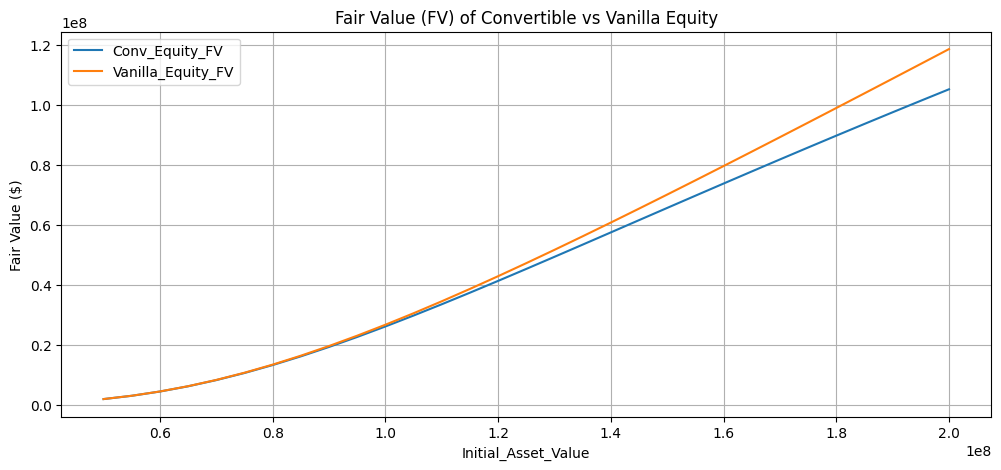

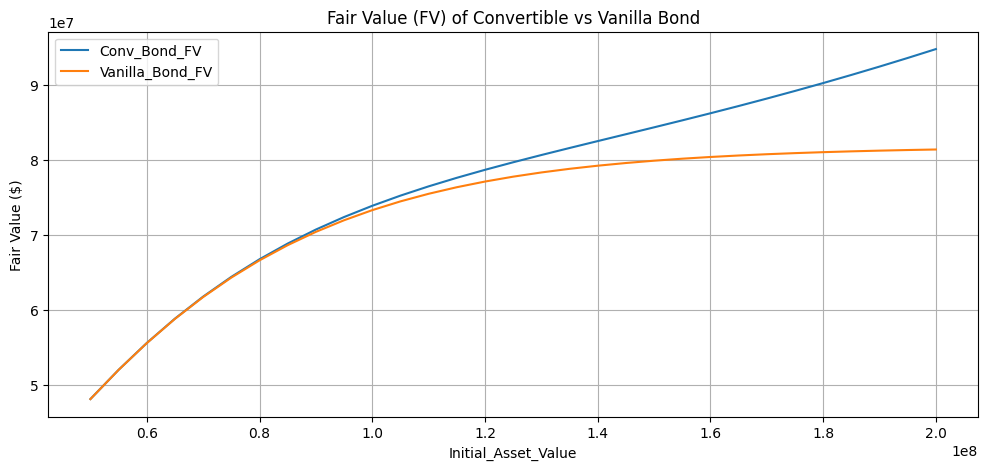

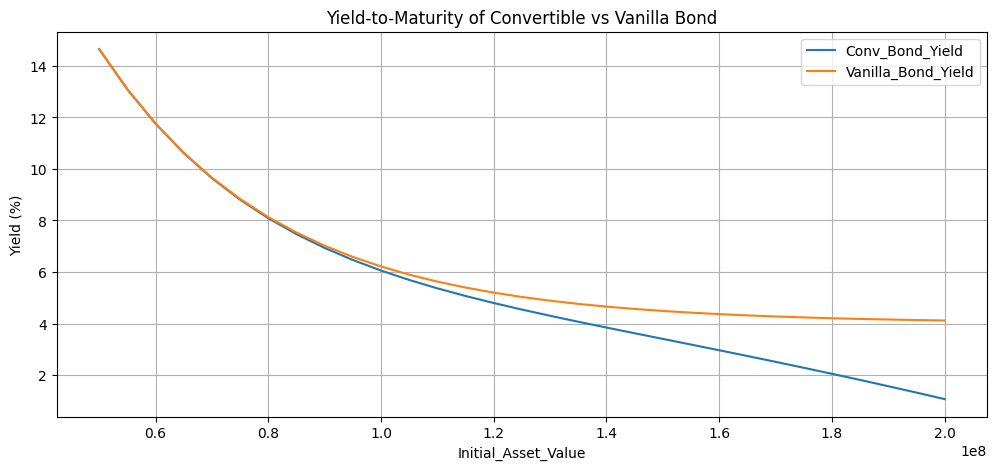

In [144]:
plt.figure(figsize=(12, 5))
plt.plot(df_metrics['Initial_Asset_Value'], df_metrics['Conv_Equity_FV'], '-', label='Conv_Equity_FV')
plt.plot(df_metrics['Initial_Asset_Value'], df_metrics['Vanilla_Equity_FV'], '-', label='Vanilla_Equity_FV')
plt.title(f'Fair Value (FV) of Convertible vs Vanilla Equity')
plt.xlabel('Initial_Asset_Value')
plt.ylabel('Fair Value ($)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(df_metrics['Initial_Asset_Value'], df_metrics['Conv_Bond_FV'], '-', label='Conv_Bond_FV')
plt.plot(df_metrics['Initial_Asset_Value'], df_metrics['Vanilla_Bond_FV'], '-', label='Vanilla_Bond_FV')
plt.title(f'Fair Value (FV) of Convertible vs Vanilla Bond')
plt.xlabel('Initial_Asset_Value')
plt.ylabel('Fair Value ($)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(df_metrics['Initial_Asset_Value'], df_metrics['Conv_Bond_Yield'] * 100, '-', label='Conv_Bond_Yield')
plt.plot(df_metrics['Initial_Asset_Value'], df_metrics['Vanilla_Bond_Yield'] * 100, '-', label='Vanilla_Bond_Yield')
plt.title(f'Yield-to-Maturity of Convertible vs Vanilla Bond')
plt.xlabel('Initial_Asset_Value')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid()
plt.show()

-----------------------------------------------------------
# Problem 3: Correlated defaults: homogeneous issuers case
## Follow Lecture 7, "Correlated Defaults"
We are analyzing a pool consisting of n = 100 equally weighted credit issuers with $100 total face notional. Our investment time horizon is T = 5 years.

The pool is homogenous, and each issuer has:
1. a flat hazard rate h = 12%,
2. a constant recovery rate given default of R of 40% and
3. a correlation $\rho$ to the systematic (market) factor.

## a. Expected pool loss to time T

Compute the expected loss in the pool until time T.

In [161]:
h = 12/100 # Hazard Rate
R = 40/100 # Recovery Rate
n = 100    # Number of issuers in the pool
T = 5      # Time
face_notional = 100 # Total Pool Face Notional

rho = np.exp(-T*h)

# Probability of default by T for each issuer
prob_default = 1 - rho

# Expected pool loss
expected_pool_loss = n * (1 - rho) * (1 - R)

print(f"Probability of Default by year {T}: {prob_default:,.2%}")
print(f'Expected Pool Loss: {expected_pool_loss:.2f}')

Probability of Default by year 5: 45.12%
Expected Pool Loss: 27.07


## b. Counting the number of issuer defaults until time T

Write a function that computes the probability of exactly k defaults until time T. 

Use Lecture 7 Section "Correlated defaults" as a reference. 
For the numerical integration, you can use and quad from scipy.integrate (or similar).

$\mathbb{P}\left[L_{T}=k\cdot\frac{\left(1-R\right)}{n}\right]=\mathbb{P}\left[\sum_{i=1}^{n}\mathbb{I}_{\{\tau_{i}\leq T\}}=k\right]=\mathbb{\int_{-\infty}^{\infty}}{n \choose k}\cdot\left(1-p_{x}\right)^{k}\cdot p_{x}^{n-k}\cdot\varphi\left(x\right)dx$

$p_{x}^{i}=\mathbb{P}\left[Z^{i}<\frac{d_{-}^{i}-\rho_{i}\cdot x}{\sqrt{1-\rho_{i}^{2}}}\right]=\Phi\left(\frac{d_{-}^{i}-\rho_{i}\cdot x}{\sqrt{1-\rho_{i}^{2}}}\right)$

$p^{i}=\Phi\left(d_{-}^{i}\right), \forall i = 1..n$

In [146]:
def prob_k_defaults(n, k, h, T, rho):
    """_summary_
    Computes the prob of k defaults out of n issuers 
    Parameters:
        n : number of issuers
        k : number of defaults
        h : flat hazard rate
        T : time horizon
        rho: asset correlation
    """
    
    # Marginal default prob
    prob_default = 1 - np.exp(-h * T)
    
    # Distance to dDefault threshold d
    d = norm.ppf(prob_default)
    
    # Integrand function over the common factor x
    def integrand(x): 
        px = norm.cdf( (d - rho *x) / np.sqrt(1-rho**2) )
        binom_term = comb(n,k)
        # This is different from slide because slide use px = survival prob
        prob_term = (px)**k * (1-px)**(n-k)
        phi_x = norm.pdf(x)
        return binom_term * prob_term * phi_x
    
    # Integrate over all x (standard normal)
    result, _ = quad(integrand, -np.inf, np.inf)
    
    return result

In [147]:
# Testing
# Inputs
h = 12/100 # Hazard Rate
R = 40/100 # Recovery Rate
n = 100    # Number of issuers in the pool
T = 5      # Time
face_notional = 100 # Total Pool Face Notional

# testing numbers
k = 10  # Number of defaults
rho = 50 / 100

default_prob_in_pool = prob_k_defaults(n, k, h, T, rho)
print(f"Probability of {k} defaults out of {n} issuers in the pool: {default_prob_in_pool:,.4%}")

Probability of 10 defaults out of 100 issuers in the pool: 0.6051%


## c. Compute the distribution of number of defaults

Generate and plot the distribution and cumulative distribution of number of defaults.

Use a $\rho$ grid: [rho from 0% to 90% in steps of 10%] for plotting (10 lines total).

Comment on the results.

In [148]:
# Inputs
h = 12/100 # Hazard Rate
R = 40/100 # Recovery Rate
n = 100    # Number of issuers in the pool
T = 5      # Time
face_notional = 100 # Total Pool Face Notional

# Arrange a Grid
k_grid = np.arange(0, n+1, 1)
step = 10/100
rho_grid = np.arange(0, 90/100 + step, step)

# List to store results:
metrics = []

for rho in rho_grid:
    pdf = np.array([prob_k_defaults(n, k, h, T, rho) for k in k_grid])
    cdf = np.cumsum(pdf)
    
    for i, k in enumerate(k_grid):
        metrics.append({
            'rho': rho,
            'k': k,
            'pdf': pdf[i],
            'cdf': cdf[i]
        })
        
df_metrics = pd.DataFrame(metrics)
display(df_metrics.head())
display(df_metrics.tail())

,rho,k,pdf,cdf
0,0.0,0,8.756520e-27,8.756520e-27
1,0.0,1,7.198900e-25,7.286465e-25
2,0.0,2,2.929584e-23,3.002448e-23
3,0.0,3,7.867655e-22,8.167900e-22
4,0.0,4,1.568526e-20,1.650205e-20


,rho,k,pdf,cdf
1005,0.9,96,0.013449,0.841945
1006,0.9,97,0.015838,0.857783
1007,0.9,98,0.019962,0.877745
1008,0.9,99,0.029377,0.907122
1009,0.9,100,0.092878,1.000000


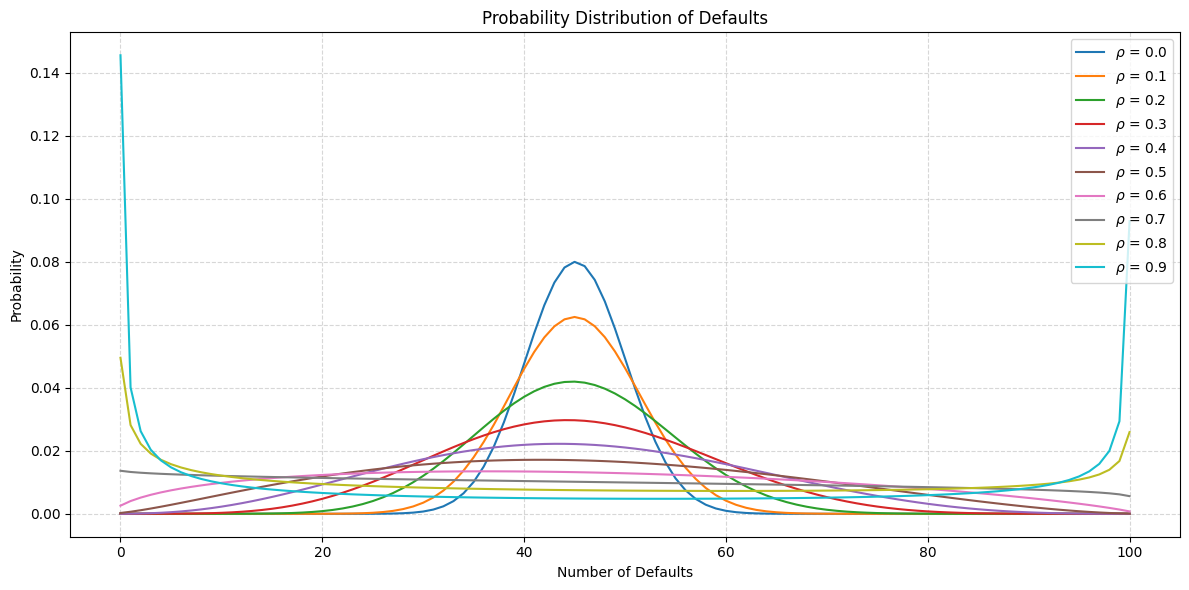

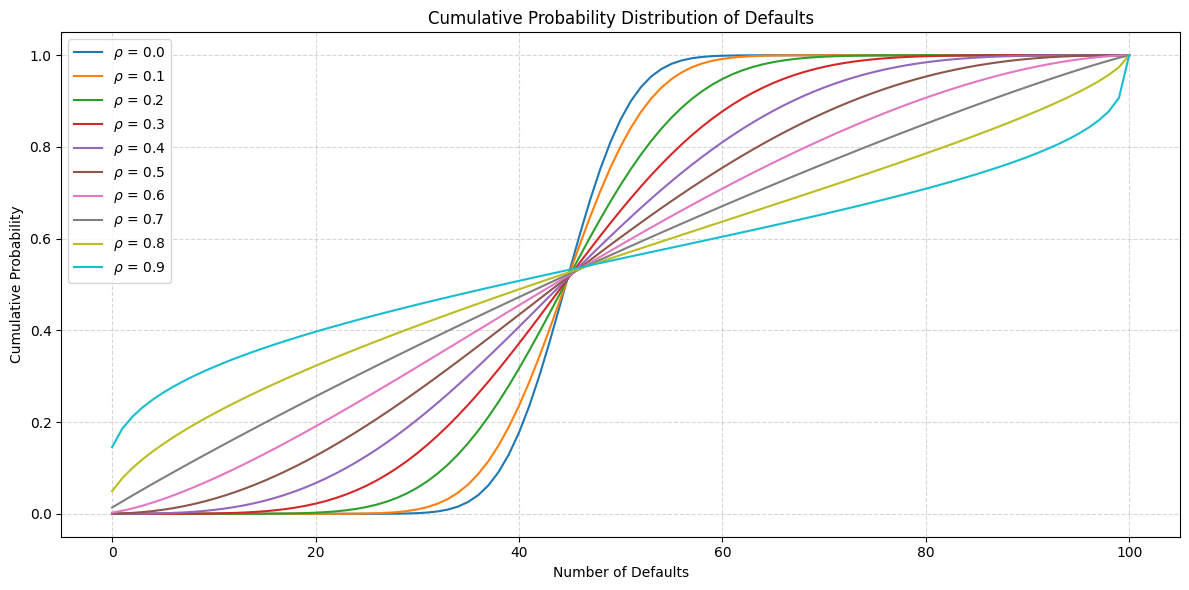

In [149]:
plt.figure(figsize=(12, 6))
for rho in df_metrics['rho'].unique():
    subset = df_metrics[df_metrics['rho'] == rho]
    plt.plot(subset['k'], subset['pdf'], label = f"$\\rho$ = {rho:.1f}")
plt.xlabel("Number of Defaults")
plt.ylabel("Probability")
plt.title("Probability Distribution of Defaults")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for rho in df_metrics['rho'].unique():
    subset = df_metrics[df_metrics['rho'] == rho]
    plt.plot(subset['k'], subset['cdf'], label = f"$\\rho$ = {rho:.1f}")
plt.xlabel("Number of Defaults")
plt.ylabel("Cumulative Probability")
plt.title("Cumulative Probability Distribution of Defaults")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Comment:

From the PDF plot: 
The higher the correlation of issuers, for extreme number of defaults (very low or very high) in the pool, the probability of default gets bigger. This makes sense: If the issuers are highly correlated to the market and there is a systemic credit default event (e.g., a global financial crisis), more issuers will default together. On the other hand, if the market environment is stable, and there's low probability of default, then most issuers will not default.

From the CDF Plot: 
- For rho = 0, defaults are independent, risk is diversified. 
- For rho = 1, either most issuers survive or most default. The curve is flatter, bigger mass on both tails. There's a higher probability of very few or lots of defaults. This represents the heavy tails we see in the real world, where there's a huge systemic risk. 

As correlation increases, which happens during a financial crisis, diversification benefit becomes less effective, and the risk for extreme losses (tail events) increases dramatically. 

## Solution
Comments: the higher the correlation of issuers, the higher the probability of pool losses concentrating in the left or right tail of the distribution (i.e. higher dispersion / standard deviation of the distribution).

## d. Compute the Mean and Standard Deviation of Pool Losses, for all correlation coefficients $\rho$ in the grid

Calculate, display and plot the Mean and Standard Deviation of pool losses for each $\rho$ in the grid.

Comment on the results.

In [150]:
notional_per_issuer = face_notional / n
print(f'Notional Value for each issuer in the pool: {notional_per_issuer}')

Notional Value for each issuer in the pool: 1.0


In [151]:
# Use the df_metrics from earlier
loss_stats = []

notional_per_issuer = face_notional / n
# print(f'Notional Value for each issuer in the pool: {notional_per_issuer}')

for rho in rho_grid:
    # Dataframe for specific rho
    df_rho = df_metrics[df_metrics['rho'] == rho]
    
    # Extract the k and PDF
    k_values = df_rho['k'].values
    pdf_values = df_rho['pdf'].values

    # Mean number of defaults
    mean_k = np.sum(k_values * pdf_values)
    
    # Std of Number of Defaults
    var_k = np.sum( (k_values - mean_k)**2 * pdf_values)
    std_k = np.sqrt(var_k)

    # Mean and Standard Deviation of Dollar Losses
    mean_loss = mean_k * notional_per_issuer * (1-R)
    std_loss = std_k * notional_per_issuer * (1-R)
    
    loss_stats.append({
        'rho': rho,
        'mean_k': mean_k,
        'std_k': std_k,
        'Mean_Pool_Loss': mean_loss,
        'Std_Pool_Loss': std_loss,
    })

df_loss_stats = pd.DataFrame(loss_stats)
display(df_loss_stats)

,rho,mean_k,std_k,Mean_Pool_Loss,Std_Pool_Loss
0,0.0,45.118836,4.976117,27.071302,2.985670
1,0.1,45.118836,6.346985,27.071302,3.808191
2,0.2,45.118836,9.320983,27.071302,5.592590
3,0.3,45.118836,12.834717,27.071302,7.700830
4,0.4,45.118836,16.566318,27.071302,9.939791
5,0.5,45.118836,20.434915,27.071302,12.260949
6,0.6,45.118836,24.446293,27.071302,14.667776
7,0.7,45.118836,28.667951,27.071302,17.200771
8,0.8,45.118836,33.264265,27.071302,19.958559
9,0.9,45.118836,38.684146,27.071302,23.210487


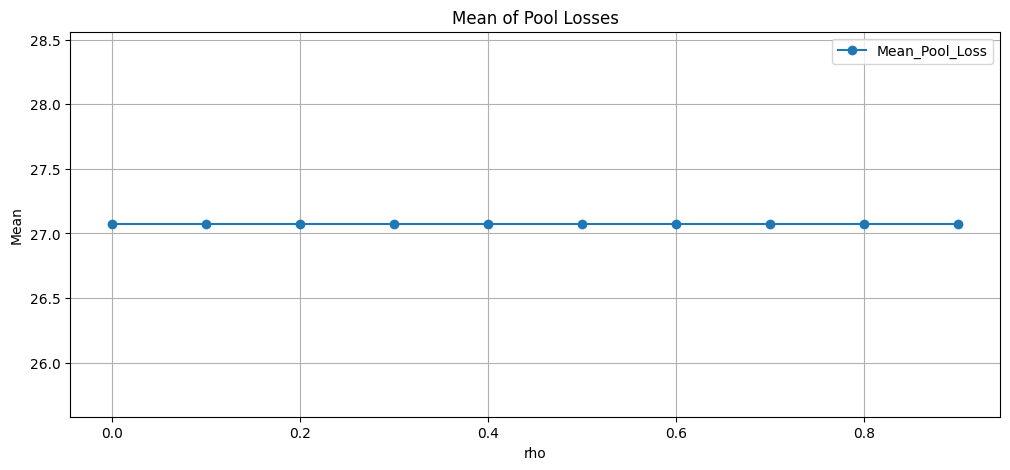

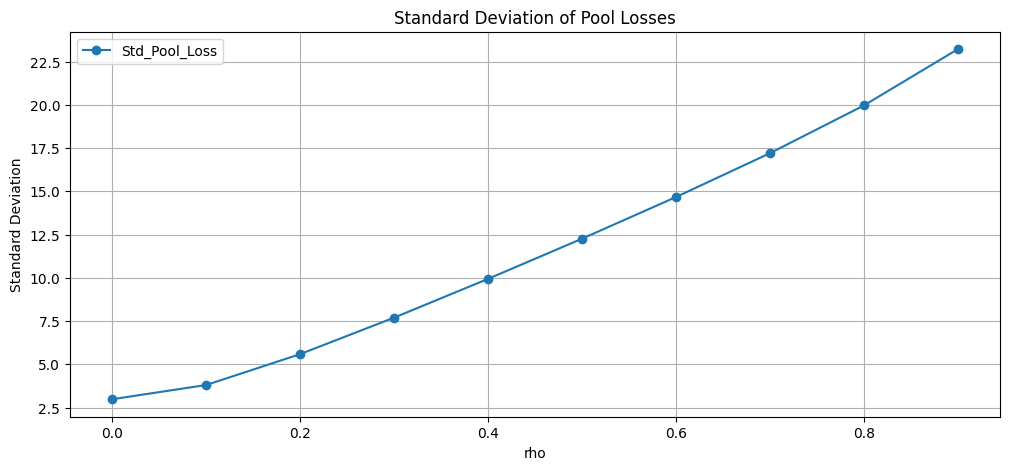

In [152]:
plt.figure(figsize=(12, 5))
plt.plot(df_loss_stats['rho'], round(df_loss_stats['Mean_Pool_Loss'], 4), 'o-', label='Mean_Pool_Loss')
plt.title(f'Mean of Pool Losses')
plt.xlabel('rho')
plt.ylabel('Mean')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(df_loss_stats['rho'], df_loss_stats['Std_Pool_Loss'], 'o-', label='Std_Pool_Loss')
plt.title(f'Standard Deviation of Pool Losses')
plt.xlabel('rho')
plt.ylabel('Standard Deviation')
plt.legend()
plt.grid()
plt.show()

Comments:

The expected pool loss remains the same across different rho. This means that no matter the issuers' correlation to the market, the expected number of defaults in a pool of 100 issuers remains constant.

The standard deviation of the pool loss is increasing in $\rho$: the higher the correlation of issuers, the higher the dispersion of the pool losses.

## Solution
Comments: 
- The manual calculation shows that mean pool loss for each $\rho$ is constant and equal to the expected pool loss computed in a. (since the expected pool loss is independent from $\rho$).

- This is also an indication that our computations have high numerical accuracy (in the order of 1e-7).

- The standard deviation of the pool loss is increasing in $\rho$: the higher the correlation of issuers, the higher the dispersion of the pool losses.

------------------------------------------------------------------
# Problem 4: Derivation of fixed rate bond PVs and DV01s in `sympy`

Starting from the fair value formula for risky fixed rate bonds in the `flat yield model`, you will derive the formulas for
* Zero coupon bonds (principal payment only, no coupons) and
* "Interest Only" / IO bonds (coupon payments only, no principal payment)

Assume T+0 settlement and zero accrued.

### Flat Yield Model Parameters
* bond face value of 100%
* bond maturity T (in years),
* semi-annual coupon c,
* flat yield y

According to formula [5] in Lecture 1, the bond present value is given by:

\begin{align}
BondPV=B(0,T,c,y)
\end{align}

\begin{align}
=\sum_{k=1}^{2T}\frac{c}{2}\cdot e^{-k\cdot\frac{y}{2}}+e^{-T\cdot y}
\end{align}

\begin{align}
= 1+\frac{\frac{c}{2}-\left( e^{\frac{y}{2}}-1 \right)}{e^{\frac{y}{2}}-1 } \cdot \left(1-e^{-T\cdot y}\right)
\end{align}


The example code below explains how to implement the present value function for the generic fixed rate bond.

It uses the 'sympy' library (symbolic mathematics) to translate mathematical formulas into a sympy symbolic equation, as described in the solution to Homework 3, Problem 2.

The sympy symbolic equation is converted into a Python function via sympy.lambdify.

The function `plot_bond_function_surface(bond_func, 'Plot Title')` plots the Python bond function on a "yield x maturity" 2D discretization grid:

* in yield space: [y from 0% to 10% in steps of 0.5%] and 
* in time-to-maturity space: [T from 1Y to 20Y in steps of 1Y].

We assume a bond coupon c of 5% for plotting purposes.

Analytic formula for bond_pv: (1 - exp(-T*y))*(c/2 - exp(y/2) + 1)/(exp(y/2) - 1) + 1


(1 - exp(-T*y))*(c/2 - exp(y/2) + 1)/(exp(y/2) - 1) + 1

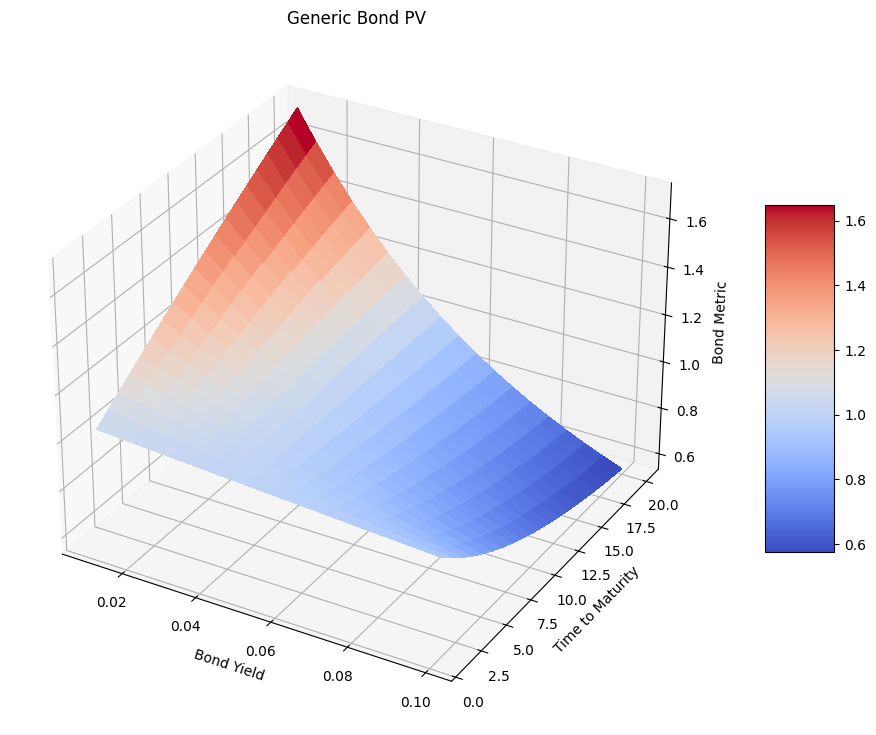

In [153]:
# define symbolic variables
t = sp.symbols('T')
c = sp.symbols('c')
y = sp.symbols('y')

# define symbolic equation for bond pv
bond_pv_eq =  1 + (c/2 -(sp.exp(y/2) - 1)) / (sp.exp(y/2) - 1) * (1 - sp.exp(-t*y))
print('Analytic formula for bond_pv:', bond_pv_eq)
display(bond_pv_eq)

# create function(y,T,y) from equation
bond_pv_func = sp.lambdify([c,t,y], bond_pv_eq)

# Plot the surface
plot_bond_function_surface(bond_pv_func, 'Generic Bond PV')


## a. Derive and plot the DV01 of a Fixed rate bond

Use the sympy "diff()" function to compute & display the derivative of the fixed rate bond PV with respect to the bond yield.

Plot the bond DV01 surface on the "yield x maturity" 2D discretization grid.


DV01:


(-T*c*exp(y/2)/2 + T*c/2 - 2*T*exp(y/2) + T*exp(y) + T - c*exp(y/2)/4 + c*exp(y*(T + 1/2))/4)*exp(-T*y)/(-2*exp(y/2) + exp(y) + 1)

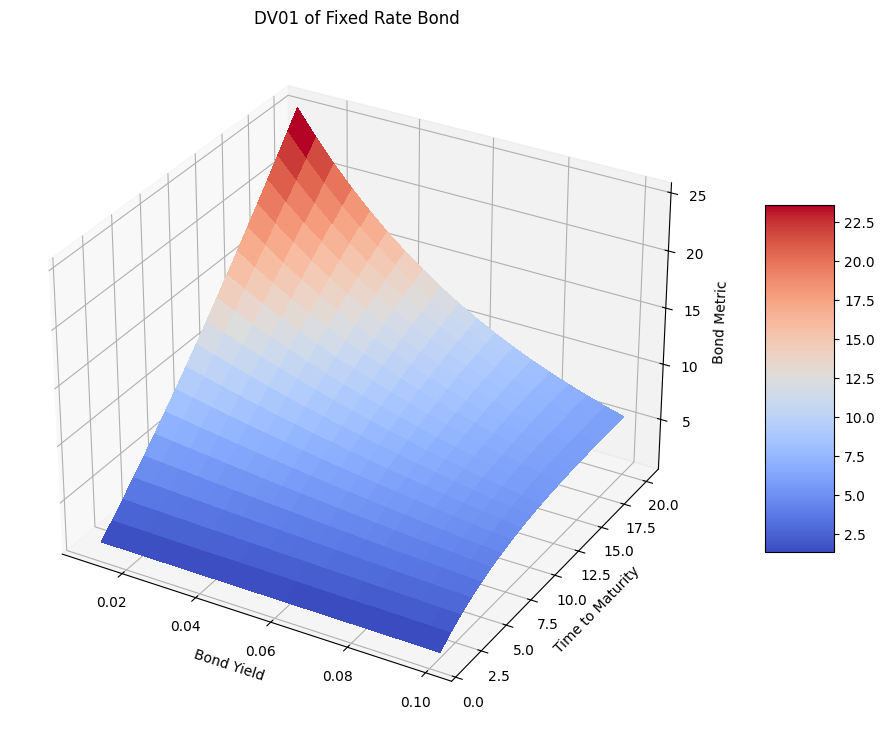

In [154]:
# dB/dy = -D * B
# DV01 = - dB/dy = D * B

dB_dy = sp.diff(bond_pv_eq, y)
DV01_fixed_rate_bond = - dB_dy

print('DV01:')
display(sp.simplify(DV01_fixed_rate_bond))

# create function(y,T,y) from equation
DV01_func = sp.lambdify([c,t,y], DV01_fixed_rate_bond)

# Plot the surface
plot_bond_function_surface(DV01_func, 'DV01 of Fixed Rate Bond')

## b. Derive and plot the present value functions for a Zero Coupon bond.

Derive and display the analytic formula for a Zero Coupon bond PV.

Plot the Zero Coupon bond PV surface on the "yield x maturity" 2D discretization grid.

Analytic formula for zero-coupon bond PV: exp(-T*y)


exp(-T*y)

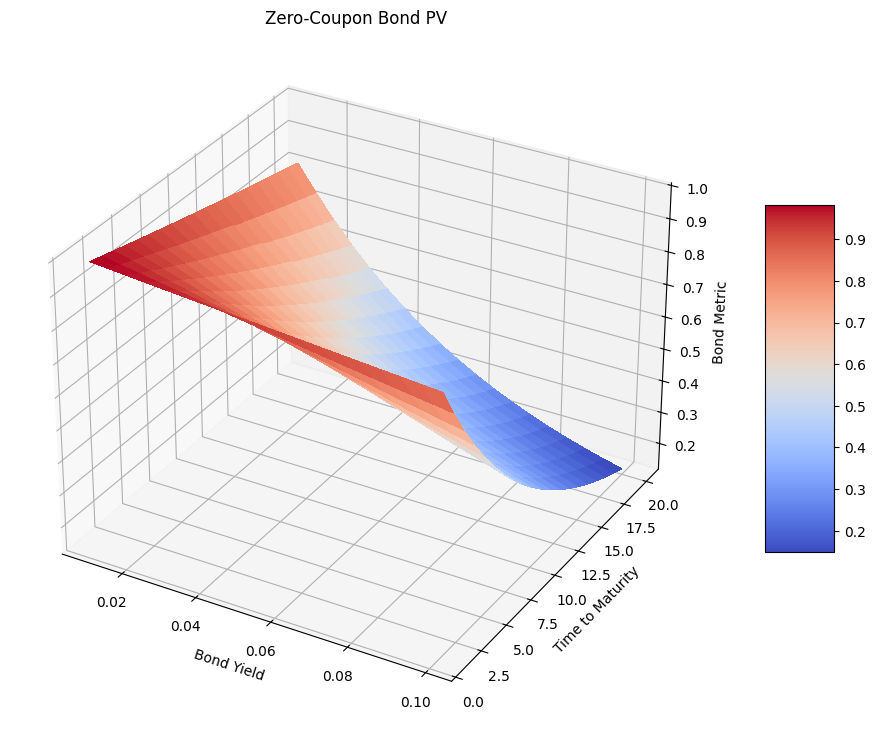

In [155]:
zc_bond_pv_eq = sp.exp(-t*y)

print('Analytic formula for zero-coupon bond PV:', zc_bond_pv_eq)
display(zc_bond_pv_eq)

# create function(y,T,y) from equation
zc_bond_pv_func = sp.lambdify([c,t,y], zc_bond_pv_eq)

# Plot the surface
plot_bond_function_surface(zc_bond_pv_func, 'Zero-Coupon Bond PV')

## c. Derive and plot the DV01 of a Zero Coupon bond.

Use the sympy "diff()" function to compute & display the derivative of the Zero Coupon bond PV with respect to the bond yield.

Plot the Zero Coupon bond DV01 surface on the "yield x maturity" 2D discretization grid.


DV01:


T*exp(-T*y)

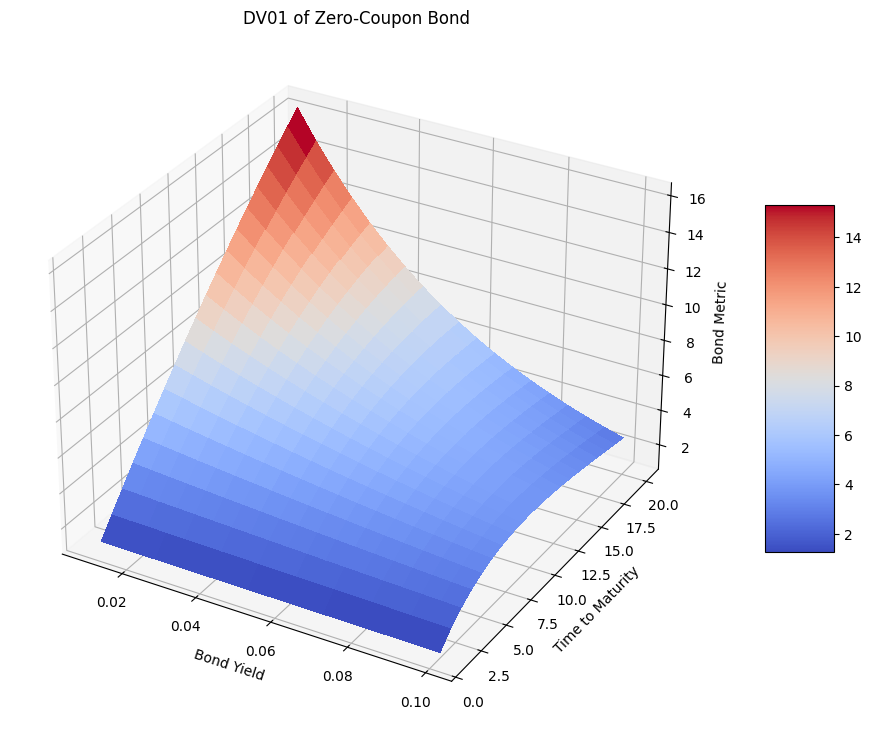

In [156]:
# dB/dy = -D * B
# DV01 = - dB/dy = D * B

dB_dy_zv = sp.diff(zc_bond_pv_eq, y)
DV01_zc = - dB_dy_zv

print('DV01:')
display(sp.simplify(DV01_zc))

# create function(y,T,y) from equation
DV01_zc_func = sp.lambdify([c,t,y], DV01_zc)

# Plot the surface
plot_bond_function_surface(DV01_zc_func, 'DV01 of Zero-Coupon Bond')

## d. Derive and plot the present value function for an Interest Only bond.

Derive and display the analytic formula for an Interest Only bond PV.

Plot the Interest Only bond PV surface on the "yield x maturity" 2D discretization grid.

Keep in mind that any generic fixed rate bond can be decomposed into Zero Coupon and Interest Only components.

Analytic formula for Interest Only bond_pv: c*(1 - exp(-T*y))*exp(-y/2)/(2*(1 - exp(-y/2)))


c*(1 - exp(-T*y))*exp(-y/2)/(2*(1 - exp(-y/2)))

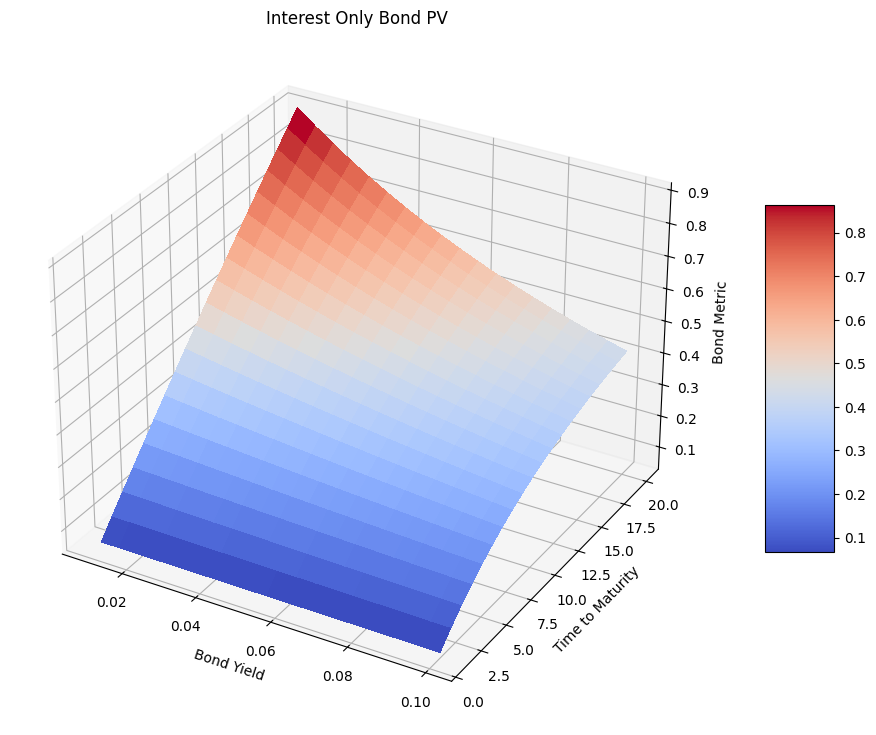

In [157]:
# define symbolic equation for bond pv
io_bond_pv_eq = (c/2) * (sp.exp(-y/2) * (1-sp.exp(-y*t))) / (1-sp.exp(-y/2))
print('Analytic formula for Interest Only bond_pv:', io_bond_pv_eq)
display(io_bond_pv_eq)

# create function(y,T,y) from equation
io_bond_pv_func = sp.lambdify([c,t,y], io_bond_pv_eq)

# Plot the surface
plot_bond_function_surface(io_bond_pv_func, 'Interest Only Bond PV')

## e. Derive and plot the DV01 of an Interest Only bond.

Use the sympy "diff()" function to compute and display the derivative of the Interest Only bond PV.

Plot the Interest Only bond DV01 surface on the "yield x maturity" 2D discretization grid.


DV01:


c*(-(1 - exp(y/2))*(-2*T + exp(T*y) - 1) + exp(T*y) - 1)*exp(-T*y)/(4*(1 - exp(y/2))**2)

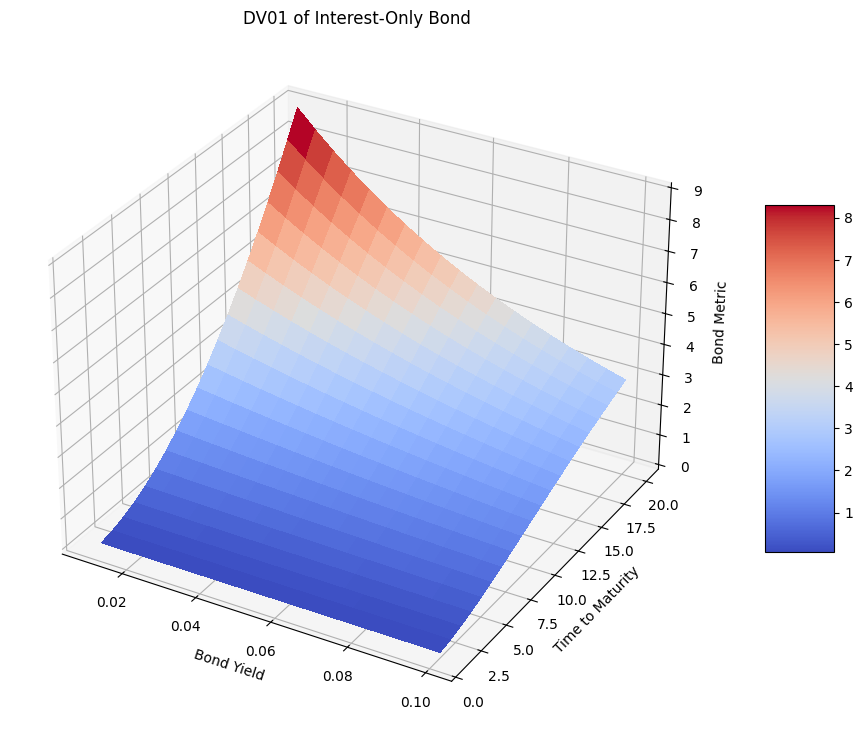

In [158]:
# dB/dy = -D * B
# DV01 = - dB/dy = D * B

dB_dy_io = sp.diff(io_bond_pv_eq, y)
DV01_io_bond = - dB_dy_io

print('DV01:')
display(sp.simplify(DV01_io_bond))

# create function(y,T,y) from equation
DV01_io_bond_func = sp.lambdify([c,t,y], DV01_io_bond)

# Plot the surface
plot_bond_function_surface(DV01_io_bond_func, 'DV01 of Interest-Only Bond')

## f. For which bond coupon $c^*$ are the Interest Only PV and the Zero Coupon PV equal?
 
### Find the bond coupon $c^*$ satisfying:

\begin{align}
InterestOnlyPV(c^*, y,T) = ZeroCouponPV(y,T)
\end{align}

Display the formula for $c^*$.

In [159]:
# Equation: PV(IO Bond) = PV (ZC Bond)
eq_to_solve = sp.Eq(io_bond_pv_eq, zc_bond_pv_eq)

# Solve for c
solution = sp.solve(eq_to_solve, c)[0]

print('Formula for c* :')
display(solution)

Formula for c* :


2*(1 - exp(y/2))/(1 - exp(T*y))